In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import statsmodels.api as sm
from functools import reduce

%matplotlib inline

In [59]:
df_mkt = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='MKT',header=18,index_col=0,parse_dates=True)[['USA']]
df_smb = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='SMB',header=18,index_col=0,parse_dates=True)[['USA']]
df_hml = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='HML FF',header=18,index_col=0,parse_dates=True)[['USA']]
df_umd = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='UMD',header=18,index_col=0,parse_dates=True)[['USA']]
df_mkt.columns = ['MKT']
df_smb.columns = ['SMB']
df_hml.columns = ['HML']
df_umd.columns = ['UMD']

In [61]:
## risk-free rate
df_rf = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)
df_rf_monthly = df_rf.groupby([df_rf.index.year,df_rf.index.month]).apply(lambda x: x.tail(1))
df_rf_monthly = (1+df_rf_monthly.shift(-1))**20 - 1
df_rf_monthly = df_rf_monthly.droplevel([0,1])
df_rf_monthly = df_rf_monthly.fillna(method='ffill')

In [62]:
df_factors = reduce(lambda x,y:pd.merge(x,y,how='inner',left_index=True, right_index=True),[df_mkt,df_smb,df_hml,df_umd,df_rf_monthly])
df_factors

,MKT,SMB,HML,UMD,Risk Free Rate
DATE,,,,,
1927-01-31,-0.001355,-0.006948,0.051691,0.026664,0.002499
1927-02-28,0.039274,0.003522,0.027370,-0.009261,0.002884
1927-03-31,-0.000313,-0.010440,-0.007039,0.051651,0.002403
1927-04-30,0.005255,0.009116,0.005918,0.030603,0.002884
1927-05-31,0.055110,0.015048,0.035377,0.053263,0.002499
...,...,...,...,...,...
2020-07-31,0.055872,-0.013775,-0.019973,0.069709,0.000072
2020-08-31,0.071012,-0.002214,-0.014737,-0.001434,0.000088
2020-09-30,-0.035672,0.004038,-0.014113,0.035101,0.000080


In [6]:
tickers = []
lst_rets = []
lst_betas = []
bad_tickers = list(pd.read_csv('../data/US Stocks Data/Kibor Bad Tickers/bad_ticker_v1.txt').values.flatten())
files = glob.glob('../data/Ex Ante Beta/*')

In [7]:
for file in files:
    ticker = re.search('../data/Ex Ante Beta/(.+)\.pickle', file).group(1)
    if ticker in bad_tickers:
        continue
    lst_ret = pd.read_pickle(file)[['ret']]
    lst_beta = pd.read_pickle(file)[['beta_est']]
    
    lst_rets.append(lst_ret)
    lst_betas.append(lst_beta)
    tickers.append(ticker)
print('finished combined lst of returns and betas')
df_rets = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),lst_rets)
print('finished combined df of returns')
df_betas = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),lst_betas)
print('finished combined df of betas')
df_rets.columns = tickers
df_betas.columns = tickers

finished combined lst of returns and betas
finished combined df of returns
finished combined df of betas


In [8]:
#### BaB portfolio (daily rebalancing) ####
def portfolio_daily(beta, dailyReturnDF, rf):
    """
    daily rebalancing
    """
    betaRank = beta.rank(axis = 1) # same value: average their rank
    median = betaRank.mean(axis = 1) # average rank on each day
    k = 2 / abs(betaRank.subtract(median, axis = 0)).sum(axis = 1) # normalizing constant on each day
    w = betaRank.subtract(median, axis = 0).mul(k, axis = 0) # weight (+: high beta, -: low beta)
    
    # BaB factor
    wH = w.applymap(lambda x:x if x > 0 else 0) # relative weight assigned to low beta
    wL = w.applymap(lambda x:-x if x < 0 else 0) # relative weight assigned to high beta
    
    
    returnDFBaB = dailyReturnDF.shift(-1, axis = 0)
    portfolioDailyL = (returnDFBaB.mul(wL, axis = 1).sum(axis = 1) - rf) / (beta.mul(wL, axis = 1).sum(axis = 1))
    portfolioDailyH = (returnDFBaB.mul(wH, axis = 1).sum(axis = 1) - rf) / (beta.mul(wH, axis = 1).sum(axis = 1))
    portfolioDaily = portfolioDailyL - portfolioDailyH
    
    # adjust index
    newIdx = pd.Index(list(portfolioDaily.index)[1:])
    portfolioDaily = portfolioDaily[:-1,]

    portfolioDaily.index = newIdx
    return portfolioDaily

In [9]:
bab_daily = portfolio_daily(df_betas,df_rets, 0)

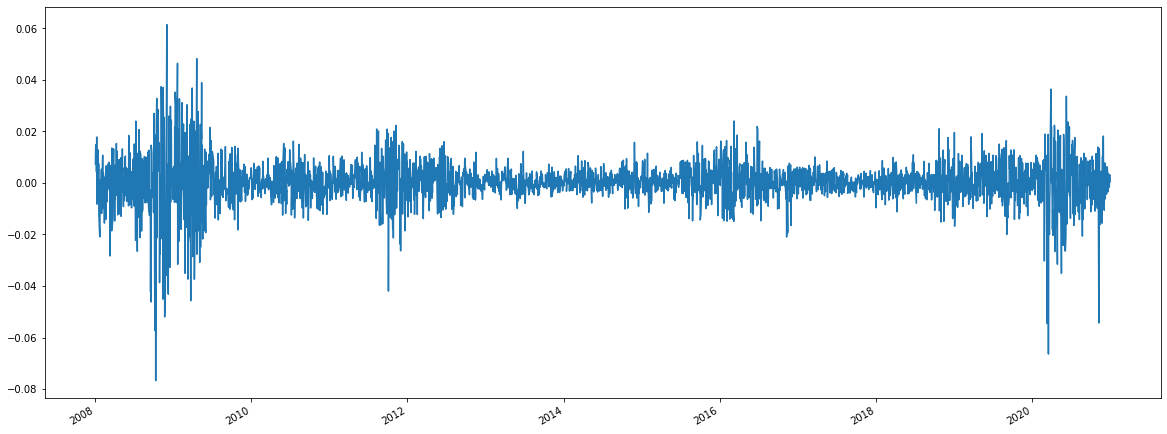

In [10]:
bab_daily.plot(figsize = (20,8))

In [11]:
def monthly_returns(df):
    """
    monthly returns
    """
    total_return_from_returns = lambda returns:(returns + 1).prod() - 1 # Returns the return between the first and last value of the DataFrame
    monthlyReturn = lambda series:series.groupby([series.index.year, series.index.month])\
    .apply(total_return_from_returns)

    monthlyReturnDF = df.apply(monthlyReturn, axis = 0)
    
    return monthlyReturnDF

In [12]:
monthly_rets_df = monthly_returns(df_rets)
monthly_rets_df 

CJ     WHLRP      ASPS       DEO        GY      TGNA      MMSI  \
2007 12  0.0  0.000000  0.000000 -0.006536 -0.006098  0.020886 -0.025868   
2008 1   0.0  0.000000  0.000000 -0.063531 -0.011808 -0.067034  0.144374   
     2   0.0  0.000000  0.000000  0.011784 -0.120669 -0.185112 -0.021579   
     3   0.0  0.000000  0.000000 -0.001259 -0.025597 -0.033318 -0.008139   
     4   0.0  0.000000  0.000000  0.004824 -0.173134 -0.027863 -0.076374   
...      ...       ...       ...       ...       ...       ...       ...   
2020 8   0.0  0.167402 -0.252780 -0.075275  0.000000  0.057908  0.093748   
     9   0.0 -0.088784  0.092921  0.018354  0.000000 -0.061634 -0.123513   
     10  0.0  0.089420 -0.122218 -0.056251  0.000000  0.017574  0.144882   
     11  0.0  0.037247  0.161248  0.182262  0.000000  0.189845  0.095735   
     12  0.0  0.166270 -0.025999  0.023405  0.000000 -0.029130  0.003799   

             QCOM      MCEP      ESRX  ...  ALL.E       TDA       CEB  \
2007 12 -0.003637  0.000000  0.000151  ...    0.0  0.000000 -0.008668   
2008 1   0.053448  0.000000 -0.084055  ...    0.0  0.000000 -0.050845   
     2   0.008884  0.000000 -0.130546  ...    0.0  0.000000 -0.327243   
     3  -0.041474  0.000000  0.079929  ...    0.0  0.000000  0.003529   
     4   0.049528  0.000000  0.080631  ...    0.0  0.000000  0.066102   
...           ...       ...       ...  ...    ...       ...       ...   
2020 8   0.122669 -0.293974  0.000000  ...    0.0  0.020292  0.000000   
     9  -0.013678 -0.170132  0.000000  ...    0.0  0.019654  0.000000   
     10  0.043544 -0.137387  0.000000  ...    0.0 -0.027103  0.000000   
     11  0.180968  0.345820  0.000000  ...    0.0  0.029413  0.000000   
     12  0.032599  0.220010  0.000000  ...    0.0 -0.003246  0.000000   

             CORR      ONCS       RES      NURO  IPL.D      ARQL      DOGZ  
2007 12  0.000000  0.000000 -0.030404  0.000000    0.0  0.008535  0.000000  
2008 1   0.000000  0.000000 -0.099224  0.122771    0.0 -0.187805  0.000000  
     2   0.000000  0.000000  0.216833 -0.860403    0.0 -0.073175  0.000000  
     3   0.000000  0.000000  0.137710 -0.288295    0.0 -0.078729  0.000000  
     4   0.000000  0.000000 -0.180393  0.213859    0.0 -0.114243  0.000000  
...           ...       ...       ...       ...    ...       ...       ...  
2020 8   0.007281 -0.175839  0.040466 -0.139077    0.0  0.000000  0.000000  
     9  -0.363103 -0.071842 -0.179091 -0.030444    0.0  0.000000  0.000000  
     10 -0.214793  0.103945 -0.108120 -0.094015    0.0  0.000000  0.000000  
     11  0.167515  0.311573  0.234154  0.301971    0.0  0.000000  0.000000  
     12  0.111715  0.193310  0.022099  0.364183    0.0  0.000000  0.079995  

[157 rows x 8277 columns]

In [13]:
def portfolio_monthly(beta, monthlyReturnDF, rf = 0):
    betaRank = beta.rank(axis = 1) # same value: average their rank
    median = betaRank.mean(axis = 1) # average rank on each day
    k = 2 / abs(betaRank.subtract(median, axis = 0)).sum(axis = 1) # normalizing constant on each day
    w = betaRank.subtract(median, axis = 0).mul(k, axis = 0) # weight (+: high beta, -: low beta)
    
    tail = lambda x:x.tail(1)
    monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
    wMonthly = w.apply(monthly, axis = 0)
    betaMonthly = beta.apply(monthly, axis = 0)

    wMonthlyL = wMonthly.applymap(lambda x:-x if x < 0 else 0) # relative weight assigned to high beta
    wMonthlyH = wMonthly.applymap(lambda x:x if x > 0 else 0) # relative weight assigned to low beta


    monthlyIdx = wMonthly.index & betaMonthly.index
    monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)


    portfolioMonthlyL = (monthlyReturnDFBaB.mul(wMonthlyL, axis = 1).sum(axis = 1) - rf) / (betaMonthly.mul(wMonthlyL, axis = 1).sum(axis = 1))
    portfolioMonthlyH = (monthlyReturnDFBaB.mul(wMonthlyH, axis = 1).sum(axis = 1) - rf) / (betaMonthly.mul(wMonthlyH, axis = 1).sum(axis = 1))
    portfolioMonthly = portfolioMonthlyL - portfolioMonthlyH
    
    # adjust index
    newIdx = pd.Index(list(portfolioMonthly.index)[1:])
    portfolioMonthly = portfolioMonthly[:-1,]

    portfolioMonthly.index = newIdx
    
    # reset index ( to datetime)
    portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1]) 
    
    return portfolioMonthly

In [14]:
bab_monthly = portfolio_monthly(df_betas, monthly_rets_df)

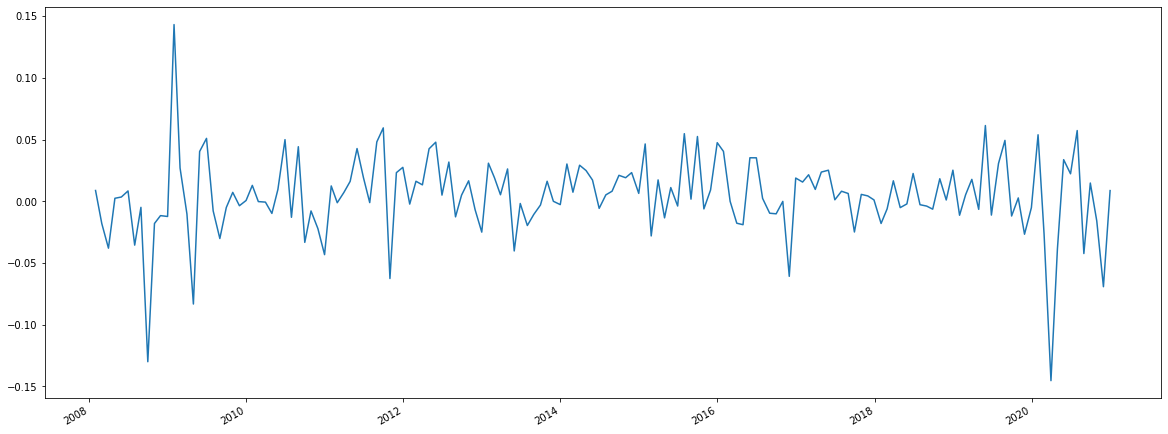

In [15]:
bab_monthly.plot(figsize = (20,8))

In [16]:
#### Equal-weighted BaB portfolio (monthly rebalancing) ####
def portfolio_monthly_equal_weighted(idx, beta, monthlyReturnDF):
    beta = beta.dropna(how = 'all', axis = 0)
    median = beta.mean(axis = 1) # average rank on each day
    
    # assign weight to those whose beta larger than mean
    compare_1 = lambda x: 1 if x else 0
    assign_1 = lambda x: (x > median).apply(compare_1)
    tmp_w = beta.apply(assign_1, axis = 0)
    
    avg = lambda x: x.divide(tmp_w.sum(axis = 1))
    wH = tmp_w.apply(avg, axis = 0)
    
    
    # assign weight to those whose beta lower than mean
    compare_2 = lambda x: 1 if x else 0
    assign_2 = lambda x: (x <= median).apply(compare_2)
    tmp_w = beta.apply(assign_2, axis = 0)
    
    avg_2 = lambda x: x.divide(tmp_w.sum(axis = 1))
    wL = tmp_w.apply(avg_2, axis = 0)
    
    w = wL - wH
    
    # monthly
    tail = lambda x:x.tail(1)
    
    monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
    wMonthly = w.apply(monthly, axis = 0)
    betaMonthly = beta.apply(monthly, axis = 0)

    # pick monthly return
    monthlyIdx = wMonthly.index & betaMonthly.index
    monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)
    
    portfolioMonthly = (monthlyReturnDFBaB * wMonthly).sum(axis = 1)

    
    # adjust index
    newIdx = pd.Index(list(portfolioMonthly.index)[1:])
    portfolioMonthly = portfolioMonthly[:-1,]

    portfolioMonthly.index = newIdx
    
    # reset index ( to datetime)
    portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1]) 
    
    return portfolioMonthly

In [17]:
#### Equal-weighted BaB portfolio with quantile(monthly rebalancing) ####
def portfolio_monthly_equal_weighted_quantile(beta, monthlyReturnDF):
    beta = beta.dropna(how = 'all', axis = 0)
    
    quantiles_portfolio = []
    betas_ex_ante = pd.DataFrame(index = ['Beta_ex_ante'])

    
    # assign weight to each quantile
    for idx,quantile in enumerate(np.arange(0,1,0.1),start = 1):
        low = beta.quantile(quantile, axis = 1)
        high = beta.quantile(quantile + 0.1, axis = 1)
        compare_1 = lambda x: 1 if x else 0
        assign_1 = lambda x: ((x >= low) & (x < high)).apply(compare_1)
        tmp_w = beta.apply(assign_1, axis = 0)
    
        avg = lambda x: x.divide(tmp_w.sum(axis = 1))
        w = tmp_w.apply(avg, axis = 0)
        
        #ex ante beta
        betas_ex_ante['P' + str(idx)] = (beta * w).sum(axis = 1).mean()
    
    
            # monthly
        tail = lambda x:x.tail(1)

        monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
        wMonthly = w.apply(monthly, axis = 0)

        betaMonthly = beta.apply(monthly, axis = 0)
        

        # pick monthly return
        monthlyIdx = wMonthly.index & betaMonthly.index
        monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)

        portfolioMonthly = (monthlyReturnDFBaB * wMonthly).sum(axis = 1)


        # adjust index
        newIdx = pd.Index(list(portfolioMonthly.index)[1:])
        portfolioMonthly = portfolioMonthly[:-1,]

        portfolioMonthly.index = newIdx

        # reset index ( to datetime)
        portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1])
        
        quantiles_portfolio.append(pd.DataFrame(portfolioMonthly, columns = ['P' + str(idx)]))
        print(idx)
    
    
    df_quantiles = reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),quantiles_portfolio)
        
        
    
    return df_quantiles, betas_ex_ante

In [18]:
df_quantiles, betas_ex_ante = portfolio_monthly_equal_weighted_quantile(df_betas, monthly_rets_df)
df_quantiles

1
2
3
4
5
6
7
8
9
10


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2008-01-31,0.013786,-0.047334,-0.070655,-0.067697,-0.068088,-0.077716,-0.066945,-0.062068,-0.077476,-0.067120
2008-02-29,-0.039436,-0.016469,-0.024826,-0.030961,-0.031765,-0.042926,-0.039000,-0.044879,-0.037976,-0.025527
2008-03-31,-0.010452,-0.048176,-0.038171,-0.035905,-0.030966,-0.018373,-0.010740,-0.007199,-0.017567,-0.015861
2008-04-30,0.012718,0.024409,0.019049,0.021846,0.039203,0.035666,0.031670,0.025701,0.033109,0.046930
2008-05-30,0.003913,0.017395,0.016530,0.030178,0.034279,0.035197,0.022334,0.029416,0.020180,0.027709
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.006808,0.004509,0.005312,0.007903,0.025900,0.042901,0.032500,0.041197,0.057890,0.071378
2020-09-30,-0.010399,-0.027894,-0.035229,-0.038014,-0.037220,-0.038276,-0.042406,-0.052198,-0.056806,-0.086268
2020-10-30,-0.016257,-0.003574,-0.006212,-0.000479,-0.017222,0.005288,0.017993,0.009540,0.012260,-0.010409
2020-11-30,0.049738,0.083631,0.104076,0.124726,0.142668,0.167367,0.181916,0.199131,0.236587,0.295230


In [52]:
### ex-ante betas
betas_ex_ante

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Beta_ex_ante,0.481163,0.627457,0.765541,0.865511,0.946281,1.024274,1.106575,1.201201,1.329812,1.664106


In [19]:
df_quantiles = df_quantiles.merge(df_rf_monthly, left_index = True, right_index = True)
df_quantiles = df_quantiles - df_quantiles[['Risk Free Rate']].values
df_quantiles = df_quantiles.drop('Risk Free Rate', axis = 1)
df_quantiles

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2008-01-31,0.012249,-0.048871,-0.072192,-0.069234,-0.069625,-0.079254,-0.068482,-0.063605,-0.079013,-0.068657
2008-02-29,-0.040885,-0.017918,-0.026275,-0.032410,-0.033214,-0.044375,-0.040449,-0.046328,-0.039425,-0.026976
2008-03-31,-0.011541,-0.049264,-0.039259,-0.036993,-0.032055,-0.019461,-0.011829,-0.008287,-0.018656,-0.016949
2008-04-30,0.011589,0.023280,0.017920,0.020717,0.038074,0.034537,0.030541,0.024572,0.031980,0.045802
2008-05-30,0.002432,0.015914,0.015049,0.028697,0.032798,0.033716,0.020853,0.027935,0.018699,0.026228
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.006896,0.004421,0.005224,0.007815,0.025812,0.042813,0.032412,0.041109,0.057802,0.071290
2020-09-30,-0.010479,-0.027974,-0.035309,-0.038094,-0.037300,-0.038356,-0.042486,-0.052278,-0.056886,-0.086348
2020-10-30,-0.016329,-0.003646,-0.006284,-0.000551,-0.017294,0.005216,0.017921,0.009468,0.012188,-0.010481
2020-11-30,0.049674,0.083567,0.104012,0.124662,0.142604,0.167303,0.181852,0.199067,0.236523,0.295166


In [114]:
## excess return
df_excess_ret = pd.DataFrame(df_quantiles.mean()).T
df_excess_ret.index = ['Excess return']

In [64]:
##capm
df_capm =  pd.DataFrame(index = ['CAPM alpha'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
for idx in np.arange(1,11):

    exog = model_data[['MKT']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    df_capm['P' + str(idx)] = res.params[0] * 100

df_capm

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
CAPM alpha,-0.315009,-0.821891,-0.991194,-0.998126,-0.917687,-1.102492,-1.127712,-1.380295,-1.76721,-2.930434


In [70]:
##Three-factor alpha
df_three_factors_alpha =  pd.DataFrame(index = ['Three-factor alpha'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
for idx in np.arange(1,11):

    exog = model_data[['MKT','SMB','HML']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    df_three_factors_alpha['P' + str(idx)] = res.params[0] * 100

df_three_factors_alpha

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Three-factor alpha,-0.253732,-0.717691,-0.856357,-0.873104,-0.783554,-0.959176,-0.957558,-1.165585,-1.491138,-2.454319


In [71]:
### Four-factor alpha

df_four_factors_alpha =  pd.DataFrame(index = ['Four-factor alpha'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
for idx in np.arange(1,11):

    exog = model_data[['MKT','SMB','HML','UMD']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    df_four_factors_alpha['P' + str(idx)] = res.params[0] * 100

df_four_factors_alpha

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Four-factor alpha,-0.251253,-0.723874,-0.866323,-0.879631,-0.787627,-0.9614,-0.958057,-1.156763,-1.48013,-2.427885


In [74]:
### Beta (realized)

beta_realized =  pd.DataFrame(index = ['Beta (realized)'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
for idx in np.arange(1,11):

    exog = model_data[['MKT']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    beta_realized['P' + str(idx)] = res.params.loc['MKT']

beta_realized

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Beta (realized),0.414871,0.770395,0.927359,1.038919,1.145296,1.236386,1.320843,1.431062,1.585335,1.97096


In [82]:
### Volatility
df_volatility = pd.DataFrame(df_quantiles.std()*np.sqrt(12)* 100, columns = ['Volatility']).T
df_volatility 

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Volatility,10.460253,14.484618,17.183932,18.314871,19.77692,21.213011,22.960587,25.109424,27.947431,36.38547


In [102]:
pd.DataFrame((((1+df_quantiles).cumprod().iloc[-1])**(12/len(df_quantiles)) - 1) * 100).T

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2020-12-31,0.038795,-2.181103,-2.640956,-2.222775,-0.890999,-2.633784,-3.22522,-5.589841,-8.94201,-20.384598


In [105]:
df_rets_quantiles = pd.DataFrame((((1+df_quantiles).cumprod().iloc[-1])**(12/len(df_quantiles)) - 1) * 100).T
df_SR = df_rets_quantiles / df_volatility.values
df_SR.index = ['Sharpe Ratio']

In [115]:
pd.concat([df_excess_ret,df_capm,df_three_factors_alpha,df_four_factors_alpha,betas_ex_ante,beta_realized,df_volatility,df_SR])

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Excess return,0.000511,-0.000889,-0.000885,-0.000371,0.001001,-0.000227,-0.000396,-0.001993,-0.004336,-0.012983
CAPM alpha,-0.315009,-0.821891,-0.991194,-0.998126,-0.917687,-1.102492,-1.127712,-1.380295,-1.767210,-2.930434
Three-factor alpha,-0.253732,-0.717691,-0.856357,-0.873104,-0.783554,-0.959176,-0.957558,-1.165585,-1.491138,-2.454319
Four-factor alpha,-0.251253,-0.723874,-0.866323,-0.879631,-0.787627,-0.961400,-0.958057,-1.156763,-1.480130,-2.427885
Beta_ex_ante,0.481163,0.627457,0.765541,0.865511,0.946281,1.024274,1.106575,1.201201,1.329812,1.664106
Beta (realized),0.414871,0.770395,0.927359,1.038919,1.145296,1.236386,1.320843,1.431062,1.585335,1.970960
Volatility,10.460253,14.484618,17.183932,18.314871,19.776920,21.213011,22.960587,25.109424,27.947431,36.385470
Sharpe Ratio,0.003709,-0.150581,-0.153688,-0.121364,-0.045052,-0.124159,-0.140468,-0.222619,-0.319958,-0.560240


In [22]:
#### Monthly cumulative return between specified start and end date ####
def portfolio_monthly_cum_ret(portfolioMonthly, start, end):
    portfolioMonthly = portfolioMonthly.drop(index = portfolioMonthly.idxmin())  # after dropping the downside outlier
    portfolioMonthly = portfolioMonthly.drop(index = portfolioMonthly.idxmax())  # after dropping the downside outlier
    
    # filter date
    portfolioMonthly = portfolioMonthly.loc[(portfolioMonthly.index > start) & (portfolioMonthly.index < end)]
    
    # cumulative return
    portfolioMonthlyCum = (1 + portfolioMonthly).cumprod()
    # add 1 (initial investment) to the first row
    firstDate = portfolioMonthlyCum.index[0] - pd.Timedelta(days = portfolioMonthly.index[0].day - 1)
    first = pd.Series([initialInvest], index = [firstDate])
    portfolioMonthlyCum = pd.concat([first, portfolioMonthlyCum])
    
    return pd.DataFrame(portfolioMonthlyCum)

In [23]:
#### to csv #####
def to_csv_cum_ret(resultPath, name, data, method):
    resultName = name + '_' +  method + '.csv'
    data.index.name = 'Date'
    data.columns = [name]
    data.to_csv(resultPath / resultName)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2008-01-31,0.012249,-0.048871,-0.072192,-0.069234,-0.069625,-0.079254,-0.068482,-0.063605,-0.079013,-0.068657
2008-02-29,-0.029137,-0.065914,-0.096570,-0.099400,-0.100527,-0.120112,-0.106161,-0.106987,-0.115323,-0.093781
2008-03-31,-0.040341,-0.111931,-0.132038,-0.132716,-0.129359,-0.137236,-0.116734,-0.114388,-0.131828,-0.109140
2008-04-30,-0.029220,-0.091257,-0.116484,-0.114748,-0.096210,-0.107438,-0.089758,-0.092626,-0.104063,-0.068338
2008-05-30,-0.026859,-0.076795,-0.103187,-0.089345,-0.066568,-0.077345,-0.070777,-0.067279,-0.087310,-0.043902
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.042141,-0.313230,-0.364129,-0.332261,-0.216646,-0.409699,-0.459280,-0.608352,-0.760249,-0.956216
2020-09-30,-0.052179,-0.332442,-0.386581,-0.357698,-0.245865,-0.432341,-0.482253,-0.628826,-0.773888,-0.959996
2020-10-30,-0.067656,-0.334876,-0.390436,-0.358052,-0.258907,-0.429380,-0.472975,-0.625312,-0.771132,-0.960416
2020-11-30,-0.021343,-0.279293,-0.327034,-0.278025,-0.153225,-0.333913,-0.377134,-0.550724,-0.716999,-0.948732
